# Final Code for Sberbank Russian Housing Market Kaggle Competition

#### This notebook contains the solution for the above mentioned Kaggle Competition. It achieves the following:

### ------ RMSLE error score: 0.31477, Kaggle Rank: 60 ------

#### The Comppetition: [Sberbank Russian Housing Market](https://www.kaggle.com/c/sberbank-russian-housing-market)

## LAYOUT

#### The notebook is divided into the following parts:
#### A. Data Cleaning
#### B. Engineering DateTime and Area Related Features
#### C. Combining Macroeconomic Data and Converting the Data to Numeric
#### D. Separating Investment and Owner Data for prediction & Predicting
#### E. Combining the predictions and exporting to a csv file

In [32]:
# Importing Needed Libraries

import pandas as pd
import numpy as np
from math import log
from datetime import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Importing the train and test datafiles

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# A. Data Cleaning

In [35]:
# Some rows have living areas more than total areas. So converting living areas in those rows to null
X = train[train["life_sq"] > train["full_sq"]].index
train.ix[X, "life_sq"] = np.NaN

In [36]:
test[test["life_sq"] > test["full_sq"]]

### Notice indexes 601, 1896, 2791. They have life_sq values 10 times the full_sq, indicating that
### it's a typing error.

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
64,30538,2015-07-06,29.80,30.60,3,5,2,1960.0,1,5.3,...,46,17,4,1,11,10,0,1,58,5
119,30593,2015-07-09,100.04,104.28,2,2,2,0.0,3,1.0,...,38,10,3,0,10,9,0,0,38,4
171,30645,2015-07-14,57.80,60.00,3,12,1,2000.0,2,1.0,...,9,1,0,0,2,8,1,0,19,0
464,30938,2015-08-05,0.00,37.80,7,19,1,0.0,1,0.0,...,3,1,0,0,1,6,0,0,6,1
601,31075,2015-08-17,74.20,742.00,2,17,1,NaN,2,1.0,...,5,2,2,0,3,12,0,0,6,3
1896,32370,2015-10-23,36.10,361.00,14,14,4,0.0,1,0.0,...,4,2,2,0,2,9,0,0,7,2
2027,32501,2015-10-30,51.90,93.20,12,20,1,2015.0,3,1.0,...,50,24,5,1,10,18,0,1,65,9
2031,32505,2015-10-30,40.20,237.00,11,11,1,2016.0,2,67.0,...,80,52,20,4,12,26,0,6,106,7
2791,33265,2015-12-01,86.90,869.00,3,20,4,0.0,3,0.0,...,14,5,1,0,5,13,0,0,29,3
2804,33278,2015-12-01,14.80,33.80,11,15,1,2015.0,1,8.0,...,14,5,1,0,5,13,0,0,29,3


In [37]:
# Dealing with rows with life_sq values = 10 * full_sq values
X = [601,1896,2791]
test.ix[X, "life_sq"] = test.ix[X, "full_sq"]

# Dealing with rest of the rows with life_sq > full_sq
X = test[test["life_sq"] > test["full_sq"]].index
test.ix[X, "life_sq"] = np.NaN

#### A.1 Exploring full_sq and life_sq values and removing outliers

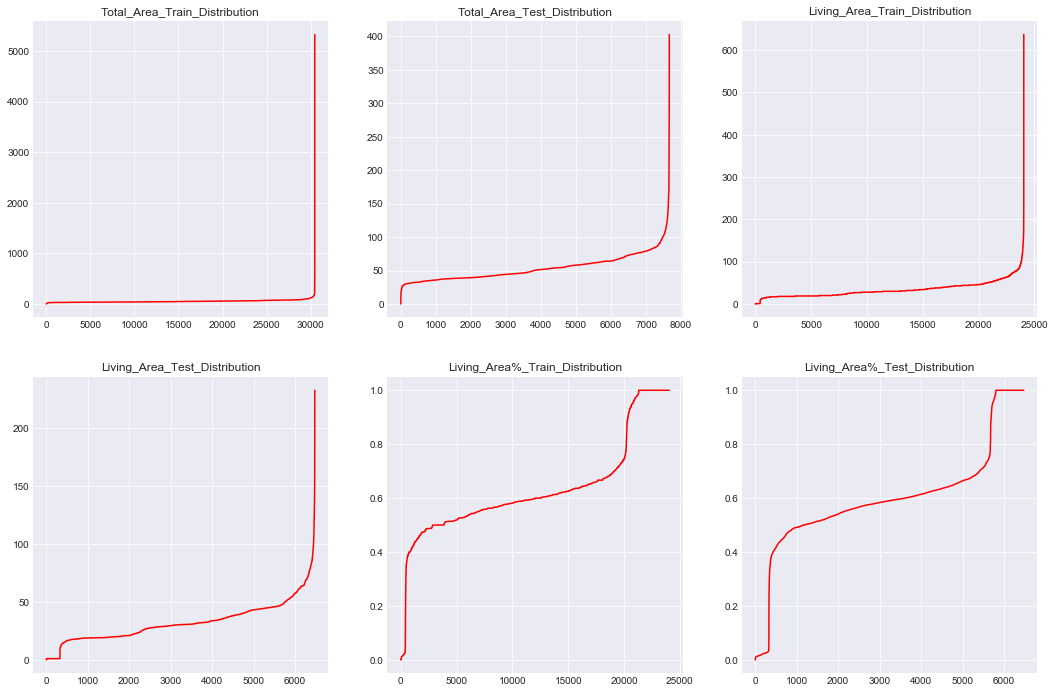

In [38]:
fig = plt.figure(figsize=(18,12))
c = train.life_sq/train.full_sq
d = test.life_sq/test.full_sq
b = 0
for i in [train["full_sq"], test["full_sq"], train["life_sq"], test["life_sq"], c, d]:
    ax = fig.add_subplot(2,3,b+1)
    titles = ["Total_Area_Train_Distribution", "Total_Area_Test_Distribution", "Living_Area_Train_Distribution", "Living_Area_Test_Distribution", "Living_Area%_Train_Distribution", "Living_Area%_Test_Distribution"]
    ax.plot(list(i.sort_values()), color="red")
    ax.set_title(titles[b])
    b+=1
plt.show()

In [39]:
# Removing lower extremities
# For lower extremities, 5 seems to be a safe threshold.

X = train[train["life_sq"] < 5].index
train.ix[X, "life_sq"] = np.NaN
X = test[test["life_sq"] < 5].index
test.ix[X, "life_sq"] = np.NaN

X = train[train["full_sq"] < 5].index
train.ix[X, "full_sq"] = np.NaN
X = test[test["full_sq"] < 5].index
test.ix[X, "full_sq"] = np.NaN

# Removing upper extremities
# Also dealing with very low living area percentage values for these large properties,
#since a property with living area < than 30% is likely to be erraneous data.

X = train[(train["full_sq"] > 210) & (train["life_sq"] / train["full_sq"] < 0.3)].index
train.ix[X, "full_sq"] = np.NaN
X = test[(test["full_sq"] > 150) & (test["life_sq"] / test["full_sq"] < 0.3)].index
test.ix[X, "full_sq"] = np.NaN

# Upper extremity filtering for living areas
X = train[train["life_sq"] > 300].index
train.ix[X, ["life_sq", "full_sq"]] = np.NaN
X = test[test["life_sq"] > 200].index
test.ix[X, ["life_sq", "full_sq"]] = np.NaN

#### A.2 Exploring kitch_sq values(Kitchen areas)

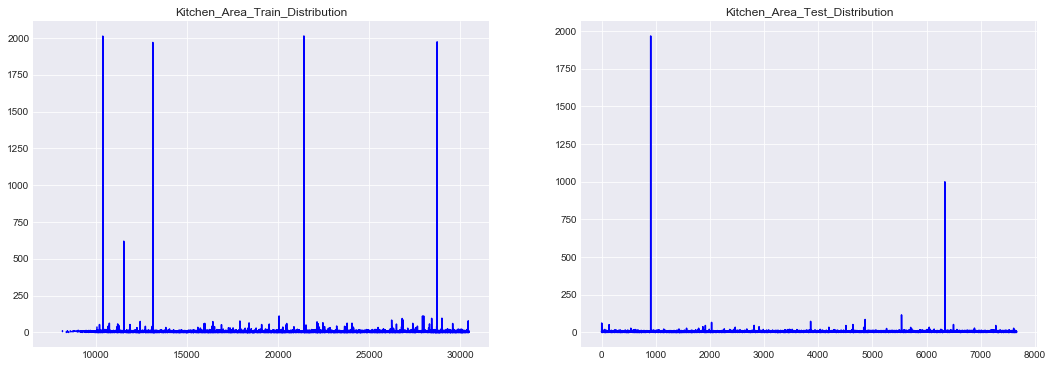

In [40]:
fig = plt.figure(figsize=(18,6))
c = list(train["kitch_sq"])
d = list(test["kitch_sq"])
b = 0
for i in [c, d]:
    ax = fig.add_subplot(1,2,b+1)
    titles = ["Kitchen_Area_Train_Distribution", "Kitchen_Area_Test_Distribution"]
    ax.plot(i, color="blue")
    ax.set_title(titles[b])
    b+=1
plt.show()

In [41]:
train[train["kitch_sq"] > 200]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
10368,10371,2013-09-10,79.0,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,...,0,0,0,1,7,1,0,12,1,7281225
11520,11523,2013-10-24,38.0,23.0,11.0,14.0,5.0,1971.0,2.0,620.0,...,4,2,0,7,16,0,9,49,11,6300000
13117,13120,2013-12-14,31.0,19.0,5.0,1.0,1.0,NaN,1.0,1970.0,...,27,5,0,27,44,0,12,117,12,3650000
21415,21418,2014-08-11,43.0,43.0,3.0,1.0,1.0,2014.0,1.0,2014.0,...,2,2,0,0,12,1,0,6,1,3801200
28734,28737,2015-03-31,31.0,16.0,2.0,12.0,5.0,1972.0,1.0,1974.0,...,0,0,0,1,2,0,2,7,2,1000000


In [42]:
# Row with index 13117 clearly has build_year as kitch_sq
train.ix[13117, "build_year"] = train.ix[13117, "kitch_sq"]

# Other rows also have anomalies, which need to be dealt with
X = train[train["kitch_sq"] > 200].index
train.ix[X, "kitch_sq"] = np.NaN

In [43]:
# Also dealing with those kitchen area values that are greater than living areas, in both train and test dfs.
X = train[train["kitch_sq"] > train["life_sq"]].index
train.ix[X, "kitch_sq"] = np.NaN

X = test[test["kitch_sq"] > test["life_sq"]].index
test.ix[X, "kitch_sq"] = np.NaN

In [44]:
# Also dealing with those kitchen area values that either 0 or 1, in both train and test dfs.
X = train[train["kitch_sq"] <= 1].index
train.ix[X, "kitch_sq"] = np.NaN
X = test[test["kitch_sq"] <= 1].index
test.ix[X, "kitch_sq"] = np.NaN

#### A.3 Exploring build year values

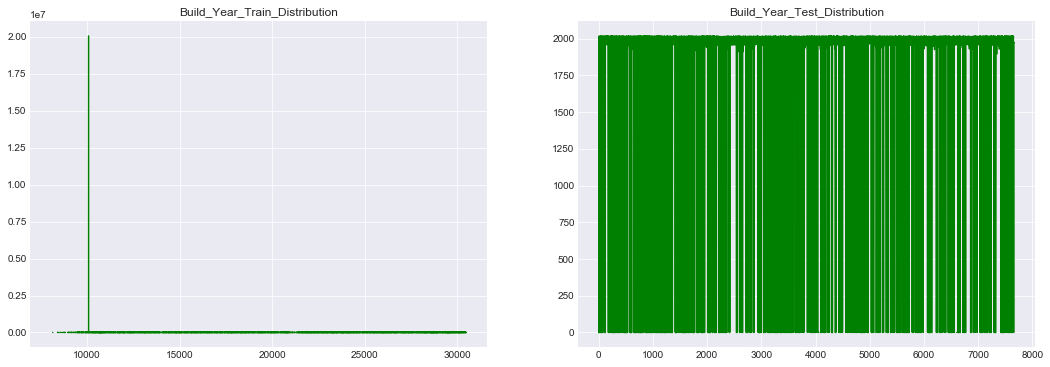

In [45]:
fig = plt.figure(figsize=(18,6))
c = list(train["build_year"])

d = list(test["build_year"])
b = 0
for i in [c, d]:
    ax = fig.add_subplot(1,2,b+1)
    titles = ["Build_Year_Train_Distribution", "Build_Year_Test_Distribution"]
    ax.plot(i, color="green")
    ax.set_title(titles[b])
    b+=1
plt.show()

In [46]:
# Exploring the extreme value(s) - build year can at maximum be the present year
train[train["build_year"] > 2018]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
10089,10092,2013-08-27,37.0,16.0,8.0,12.0,1.0,20052009.0,1.0,9.0,...,46,8,2,10,31,2,7,91,11,9000000
15220,15223,2014-02-19,41.0,24.0,4.0,9.0,2.0,4965.0,2.0,5.0,...,32,4,0,32,57,0,16,119,14,8400000


In [47]:
X = train[train["build_year"] > 2018].index
train.ix[X, "build_year"] = np.NaN

In [48]:
# Exploring build year with value less than 1500, because houses older than that cannot help much.
train[train["build_year"] < 1500].head(3)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
9441,9444,2013-07-25,73.0,73.0,5.0,22.0,1.0,0.0,3.0,NaN,...,1,1,0,1,7,0,0,6,0,5626933
9620,9623,2013-08-05,65.0,35.0,7.0,12.0,1.0,1.0,2.0,NaN,...,10,3,0,10,9,0,0,38,4,5415070
9700,9703,2013-08-08,60.0,NaN,24.0,24.0,1.0,1.0,2.0,NaN,...,1,1,0,1,7,0,0,6,0,5402275


In [49]:
# Some rows contain build years as very old. Should be dealt with as they are outliers
X = train[train["build_year"] < 1500].index
train.ix[X, "build_year"] = np.NaN
X = test[test["build_year"] < 1500].index
test.ix[X, "build_year"] = np.NaN

#### A.4 Exploring num_room (no. of rooms) values

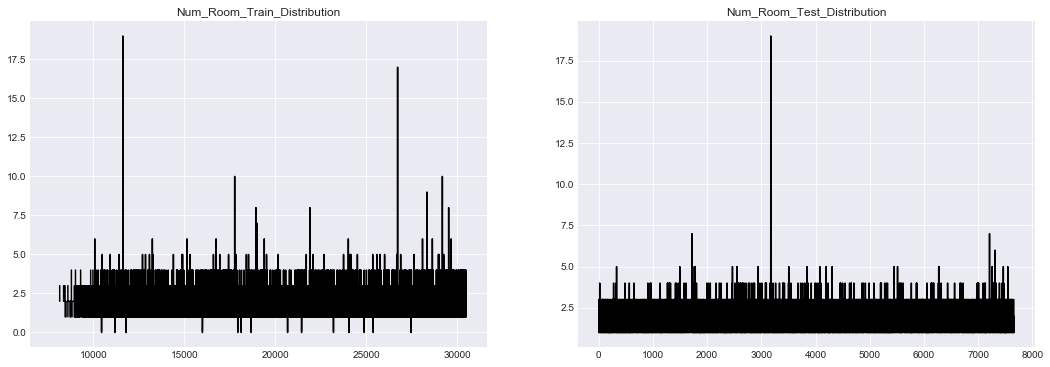

In [50]:
fig = plt.figure(figsize=(18,6))
c = list(train["num_room"])

d = list(test["num_room"])
b = 0
for i in [c, d]:
    ax = fig.add_subplot(1,2,b+1)
    titles = ["Num_Room_Train_Distribution", "Num_Room_Test_Distribution"]
    ax.plot(i, color="black")
    ax.set_title(titles[b])
    b+=1
plt.show()

In [51]:
# Dealing with rows that have number of rooms as zero

X = train[train["num_room"] == 0].index
train.ix[X, "num_room"] = np.NaN
X = test[test["num_room"] == 0].index
test.ix[X, "num_room"] = np.NaN

# Dealing with rows that have number of rooms as above 10 - considering them as outliers.

X = train[train["num_room"] > 10].index
train.ix[X, "num_room"] = np.NaN
X = test[test["num_room"] > 10].index
test.ix[X, "num_room"] = np.NaN

#### A.6 Exploring Floor and Max_Floor values

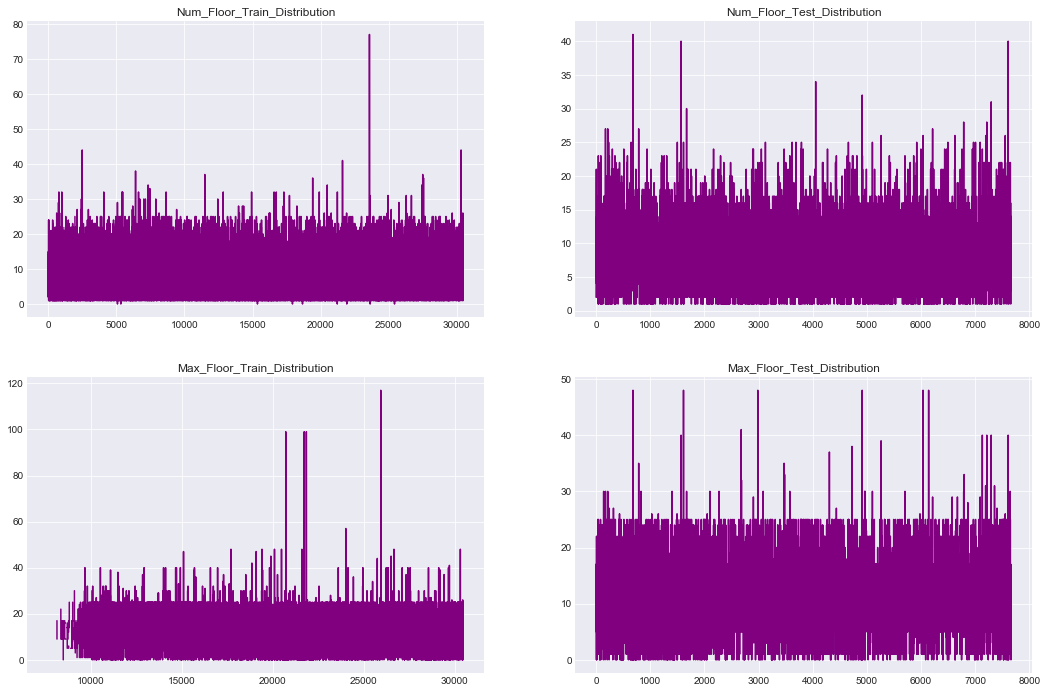

In [52]:
fig = plt.figure(figsize=(18,12))
c = list(train["floor"])
d = list(test["floor"])
e = list(train["max_floor"])
f = list(test["max_floor"])
b = 0
for i in [c, d, e, f]:
    ax = fig.add_subplot(2,2,b+1)
    titles = ["Num_Floor_Train_Distribution", "Num_Floor_Test_Distribution", "Max_Floor_Train_Distribution", "Max_Floor_Test_Distribution"]
    ax.plot(i, color="purple")
    ax.set_title(titles[b])
    b+=1
plt.show()

In [53]:
# Dealing with values that have both floor and max_floor as zero

X = train[(train["floor"] == 0) & (train["max_floor"] == 0)].index
train.ix[X, ["floor", "max_floor"]] = np.NaN

# Dealing with values that have either floor or max_floor as zero

X = train[train["floor"] == 0].index
train.ix[X, "floor"] = np.NaN

X = train[train["max_floor"] == 0].index
train.ix[X, "max_floor"] = np.NaN

X = test[test["max_floor"] == 0].index
test.ix[X, "max_floor"] = np.NaN

In [54]:
# Checking for those values where floor has greater values than max_floor
train[train["floor"] > train["max_floor"]].head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
8268,8271,2013-05-31,93.0,93.0,3.0,1.0,1.0,2013.0,3.0,NaN,...,0,0,0,0,3,0,0,0,0,5427640
9161,9164,2013-07-12,83.0,42.0,8.0,3.0,2.0,1961.0,3.0,9.0,...,359,138,26,134,233,2,99,196,13,24435000
9257,9260,2013-07-17,45.0,18.0,8.0,1.0,1.0,2014.0,1.0,NaN,...,0,0,0,1,7,1,0,12,1,4309670
9309,9312,2013-07-18,56.0,NaN,5.0,1.0,1.0,NaN,2.0,NaN,...,11,2,1,5,4,0,1,32,5,7877617
9388,9391,2013-07-23,55.0,NaN,10.0,1.0,1.0,NaN,3.0,NaN,...,2,2,0,1,12,1,0,8,0,5959900


In [55]:
# Dealing with the above anomalies
X = train[train["floor"] > train["max_floor"]].index
train.ix[X, "max_floor"] = np.NaN

X = test[test["floor"] > test["max_floor"]].index
test.ix[X, "max_floor"] = np.NaN

# From the above graph, there appears to be an outlier with great value difference.
X = train[train["floor"] > 50].index
train.ix[X, "floor"] = np.NaN

In [56]:
# A row has state marked as 33
X = train[train["state"] == 33].index
train.ix[X, "state"] = np.NaN

# B. Feature Engineering

#### B.1 Creating DateTime Features

In [57]:
import datetime
train["timestamp"] = pd.to_datetime(train["timestamp"], errors='coerce')
test["timestamp"] = pd.to_datetime(test["timestamp"], errors='coerce')

# The activity in the real estate market for each particular month is an important factor.
# Thus, creating columns for month years and the no. of houses for each month year(month_year_cnt).

month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
train["month_year"] = month_year
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

In [58]:
# Exploring the effect of month year on the prices on a bar plot

month_year_train = month_year.unique()
month_year_medians = []

for i in train["month_year"].unique():
    w = train["price_doc"][train["month_year"] == i].mean()
    month_year_medians.append(w)

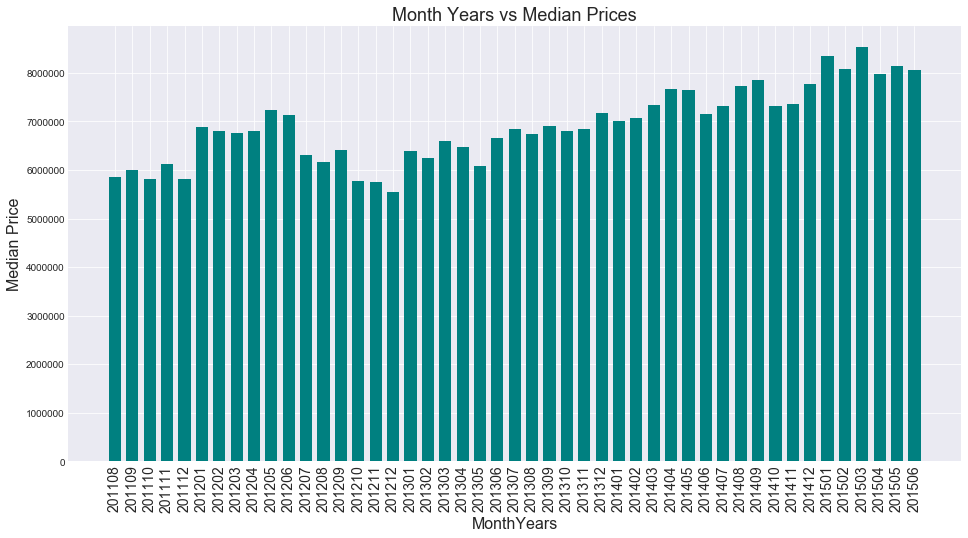

In [59]:
from numpy import arange
bar_positions = arange(len(train["month_year"].unique()))
bar_heights = month_year_medians

fig = plt.figure(figsize=(16,8))
plt.bar(bar_positions, bar_heights, 0.7, color="teal")
plt.xlabel("MonthYears", fontsize=16)
plt.ylabel("Median Price", fontsize=16)
xi = [i for i in range(0, len(train["month_year"].unique()))]
x = train["month_year"].unique()
plt.xticks(xi, x, fontsize=14)
plt.xticks(rotation=90)
plt.title("Month Years vs Median Prices", fontsize=18)
plt.show()

In [60]:
train = train.drop(columns="month_year", axis=1)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test["month_year_cnt"] = month_year.map(month_year_cnt_map)

# Creating a column for week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train["week_year_cnt"] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test["week_year_cnt"] = week_year.map(week_year_cnt_map)

# Creating a column for month and day-of-week
train["month"] = train.timestamp.dt.month
train["dow"] = train.timestamp.dt.dayofweek

test["month"] = test.timestamp.dt.month
test["dow"] = test.timestamp.dt.dayofweek

#### B.2 Creating some more area-related features

In [61]:
### Since area is one of the most important factors in real estate, creating some features around it

# Creating features for how far the floor is from the top floor, realtive area of the kitchen and average
# room size for each house

train["rel_floor"] = train["floor"] / train["max_floor"].astype(float)
train["rel_kitch_sq"] = train["kitch_sq"] / train["full_sq"].astype(float)

test["rel_floor"] = test["floor"] / test["max_floor"].astype(float)
test["rel_kitch_sq"] = test["kitch_sq"] / test["full_sq"].astype(float)

train["room_size"] = train["life_sq"] / train["num_room"].astype(float)
test["room_size"] = test["life_sq"] / test["num_room"].astype(float)

# C. Combining Macroeconomic Data and Converting the Data to Numeric

#### C.1 Combining it on TimeStamp

In [62]:
dftrain = train

dftest = test
dfmacro = pd.read_csv("macro.csv")

dftotal = pd.concat([dftrain, dftest])
dftotal = pd.merge(dftotal, dfmacro, on="timestamp", how="left")

In [63]:
# Selecting object datatype for conversion to numeric

dftotal.select_dtypes(include="object").head()

,big_market_raion,big_road1_1line,culture_objects_top_25,detention_facility_raion,ecology,incineration_raion,nuclear_reactor_raion,oil_chemistry_raion,product_type,radiation_raion,railroad_1line,railroad_terminal_raion,sub_area,thermal_power_plant_raion,timestamp,water_1line,child_on_acc_pre_school,modern_education_share,old_education_build_share
0,no,no,no,no,good,no,no,no,Investment,no,no,no,Bibirevo,no,2011-08-20 00:00:00,no,NaN,NaN,NaN
1,no,no,yes,no,excellent,no,no,no,Investment,no,no,no,Nagatinskij Zaton,no,2011-08-23 00:00:00,no,NaN,NaN,NaN
2,no,no,no,no,poor,no,no,no,Investment,yes,no,no,Tekstil'shhiki,no,2011-08-27 00:00:00,no,NaN,NaN,NaN
3,no,no,no,no,good,no,no,no,Investment,no,no,no,Mitino,no,2011-09-01 00:00:00,no,NaN,NaN,NaN
4,no,no,no,no,excellent,no,no,no,Investment,yes,yes,yes,Basmannoe,no,2011-09-05 00:00:00,no,NaN,NaN,NaN


In [64]:
# Many columns have binary values: no or yes.
# They can be directly replaced with 0 and 1

C = ["culture_objects_top_25", "thermal_power_plant_raion", "incineration_raion", "oil_chemistry_raion", "radiation_raion", "railroad_terminal_raion", "big_market_raion", "nuclear_reactor_raion", "detention_facility_raion", "water_1line", "big_road1_1line", "railroad_1line"]

for i in range(0,len(C)):
    dftotal[C[i]] = [0 if x == "no" else 1 for x in dftotal[C[i]]]

In [65]:
# Notice the product_type column carefully. While prediction, this column is going to be of great importance.

In [66]:
dftotal["product_type"].unique()

array(['Investment', 'OwnerOccupier', nan], dtype=object)

In [67]:
dftotal["product_type"] = [0 if x == "Investment" else 1 for x in dftotal["product_type"]]

# Working for Ecology column

dftotal["ecology"].unique()

array(['good', 'excellent', 'poor', 'satisfactory', 'no data'],
      dtype=object)

In [68]:
dummies = pd.get_dummies(dftotal["ecology"], prefix="ecology")
dftotal = pd.concat([dftotal, dummies], axis=1)
dftotal = dftotal.drop(["ecology", "sub_area"], axis=1)

In [69]:
dftotal.select_dtypes(include="object").head()

,timestamp,child_on_acc_pre_school,modern_education_share,old_education_build_share
0,2011-08-20 00:00:00,NaN,NaN,NaN
1,2011-08-23 00:00:00,NaN,NaN,NaN
2,2011-08-27 00:00:00,NaN,NaN,NaN
3,2011-09-01 00:00:00,NaN,NaN,NaN
4,2011-09-05 00:00:00,NaN,NaN,NaN


In [70]:
# Dropping these three columns as they have mostly NaN values. Also, removing timestamp column as
# time series data has been derived.

dftotal = dftotal.drop(["child_on_acc_pre_school", "modern_education_share", "old_education_build_share", "timestamp"], axis=1)

#### C.2 Final Preparation before Predictions

In [71]:
dftotal["full_sq"] = dftotal["full_sq"].fillna(dftotal["full_sq"].mean())

In [72]:
temp_dftrain = dftotal[:len(dftrain)]

# Creating the price per sq. metre column which will be most important.
temp_dftrain["price_sqm"] = temp_dftrain["price_doc"]/temp_dftrain["full_sq"]

temp_dftrain["full_sq"][temp_dftrain["full_sq"] == 0] = 50

#### C.3 Exploring price per sq. metre for pruning of extreme values

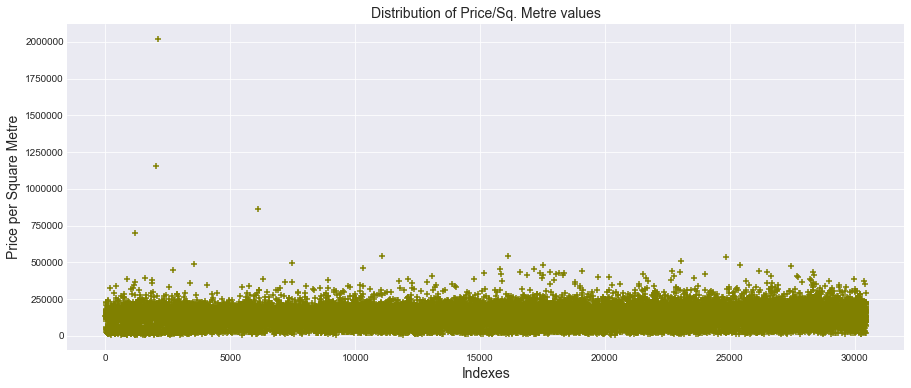

In [73]:
fig = plt.figure(figsize=(15,6))
plt.scatter(temp_dftrain.index, temp_dftrain["price_sqm"], color="olive", marker="+")
plt.ylabel("Price per Square Metre", fontsize=14)
plt.xlabel("Indexes", fontsize=14)
plt.title("Distribution of Price/Sq. Metre values", fontsize=14)
plt.show()

#### The plot above indicates that values for "price_sqm" are largely located below 600,000.

#### C.4 Exploration for lower end values

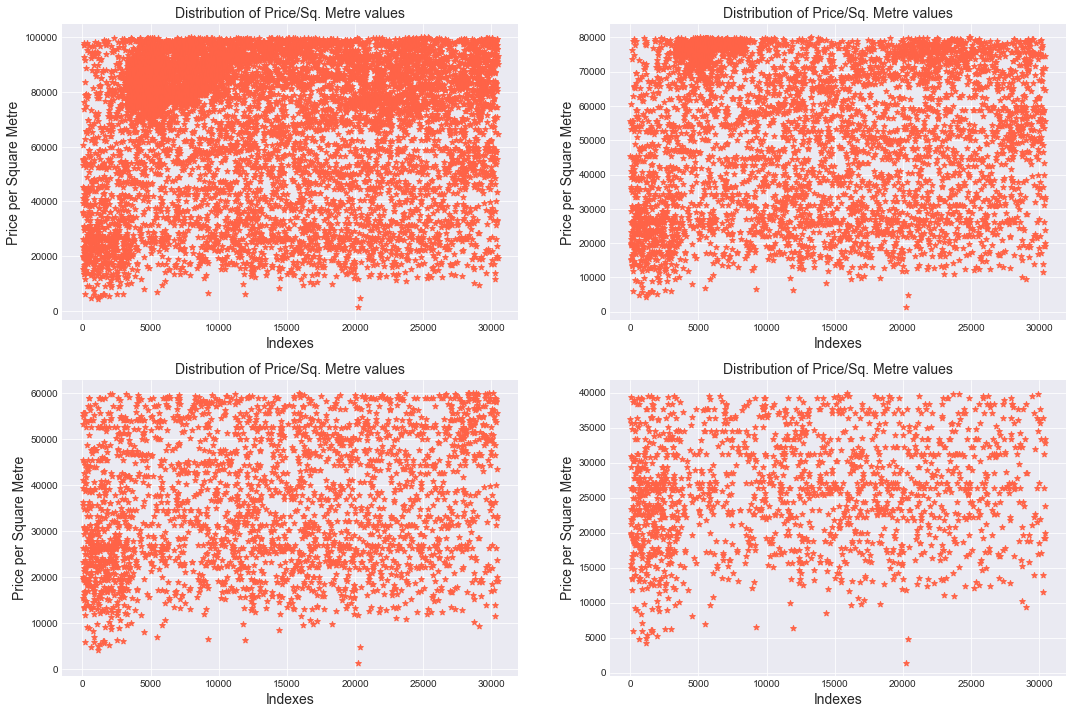

In [74]:
fig = plt.figure(figsize=(18,12))

t = [(i*20000) for i in range(0,4)]

b = 0
for j in t:
    K = temp_dftrain[temp_dftrain["price_sqm"] < (100000 - j)]
    c = K.index
    d = K["price_sqm"]
    
    ax = fig.add_subplot(2,2,b+1)
    ax.scatter(c, d, color="tomato", marker="*")
    ax.set_xlabel("Indexes", fontsize=14)
    ax.set_ylabel("Price per Square Metre", fontsize=14)
    ax.set_title("Distribution of Price/Sq. Metre values", fontsize=14)
    b+=1

plt.show()

#### The plot above indicates that values for "price_sqm" are very few below 10,000.

In [75]:
# Removing outliers greatly reduces error.
temp_dftrain = temp_dftrain[temp_dftrain["price_sqm"] < 600000]
temp_dftrain = temp_dftrain[temp_dftrain["price_sqm"] > 10000]
temp_dftrain = temp_dftrain.drop(columns="price_sqm", axis=1)

# D. Separating Investment and Owner Data for prediction

#### Separately predicting for Investment and Owner properties reduces error rate considerably.

### D.1 Performing on Investment Data

In [76]:
Xtrain_INV = temp_dftrain[temp_dftrain["product_type"] == 0] # Investment has been imputed with 0 above.
Xtrain_INV = Xtrain_INV.drop(columns=["id", "price_doc"], axis=1)
A = temp_dftrain[temp_dftrain["product_type"] == 0]

#########################
#########################
####                 ####
####    IMPORTANT    ####
####                 ####
#########################
#########################

# Predicting price per square metre also reduces the error considerably. The price can be calculated
# by multiplying the prediction by the full_sq value, ie total area.

Ytrain_INV = A["price_doc"]/A["full_sq"]

In [77]:
e = dftotal[len(dftrain):]
D = e[e["product_type"] == 0]

Xtest_INV = D
Xtest_INV = Xtest_INV.drop(columns=["id", "price_doc"], axis=1)

#### Training the XGBoost Regressor Model

In [93]:
## Selecting Parameters using GridSearchCV

#from xgboost import XGBRegressor
#from sklearn.model_selection import GridSearchCV

#xgb1 = XGBRegressor()
#parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#              'objective':['reg:linear'],
#              'learning_rate': [.03, 0.05, .07], #so called `eta` value
#              'max_depth': [5, 6, 7],
#              'min_child_weight': [3, 4],
#              'silent': [1],
#              'subsample': [0.7],
#              'colsample_bytree': [0.7],
#              'n_estimators': [200]}

#xgb_grid = GridSearchCV(xgb1,
#                        parameters,
#                        cv = 2,
#                        n_jobs = 5,
#                        verbose=True)

#xgb_grid.fit(Xtrain_INV, Ytrain_INV)

#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

In [79]:
# The above grid search gives us the parameters that are used in the following model

from xgboost import XGBRegressor

model = XGBRegressor(learning_rate = 0.05, max_depth = 5, subsample = 0.7, colsample_bytree = 0.7, silent = 1, n_estimators=200, min_child_weight = 4, early_stopping_rounds = 30)

model.fit(Xtrain_INV, Ytrain_INV)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, early_stopping_rounds=30, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

#### Plotting Feature Importance

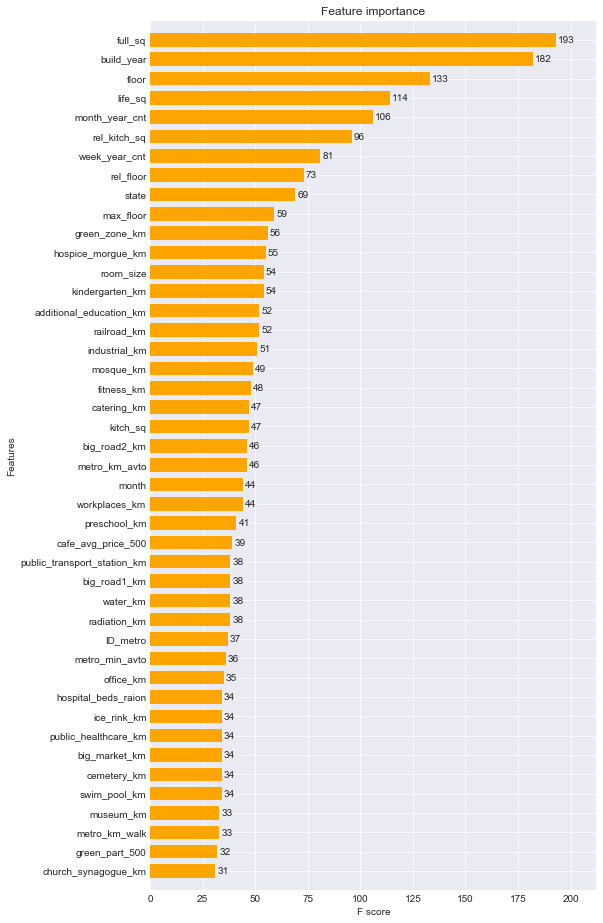

In [80]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=44, height=0.7, ax=ax, color="orange")
plt.show()

In [81]:
Ytest = model.predict(Xtest_INV)

# As stated above, the price can be calculated by multiplying the price/sq. meter prediction by total area.
# price/sq. meter * sq. meter = price

D["price_doc"] = Ytest * D["full_sq"]
INV_DATASET = D

### D.2 Performing on Owner Data

In [82]:
Xtrain_OWN = temp_dftrain[temp_dftrain["product_type"] == 1] # Investment has been imputed with 0 above.
Xtrain_OWN = Xtrain_OWN.drop(columns=["id", "price_doc"], axis=1)
A = temp_dftrain[temp_dftrain["product_type"] == 1]
Ytrain_OWN = A["price_doc"]/A["full_sq"]

In [83]:
e = dftotal[len(dftrain):]
B = e[e["product_type"] == 1]

Xtest_OWN = B
Xtest_OWN = Xtest_OWN.drop(columns=["id", "price_doc"], axis=1)

#### Training the XGBoost Regressor Model

In [94]:
## Selecting Parameters using GridSearchCV

#from xgboost import XGBRegressor
#from sklearn.model_selection import GridSearchCV

#xgb2 = XGBRegressor()
#parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#              'objective':['reg:linear'],
#              'learning_rate': [.03, 0.05, .07], #so called `eta` value
#              'max_depth': [5, 6, 7],
#              'min_child_weight': [3, 4],
#              'silent': [1],
#              'subsample': [0.7],
#              'colsample_bytree': [0.7],
#              'n_estimators': [200]}

#xgb_grid = GridSearchCV(xgb2,
#                        parameters,
#                        cv = 2,
#                        n_jobs = 5,
#                        verbose=True)

#xgb_grid.fit(Xtrain_OWN, Ytrain_OWN)

#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

In [85]:
# The above grid search gives us the parameters that are used in the following model

model = XGBRegressor(learning_rate = 0.03, max_depth = 7, subsample = 0.7, colsample_bytree = 0.7, silent = 1, n_estimators=200, min_child_weight = 3, early_stopping_rounds = 30)

model.fit(Xtrain_OWN, Ytrain_OWN)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, early_stopping_rounds=30, gamma=0,
       learning_rate=0.03, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

#### Plotting Feature Importance

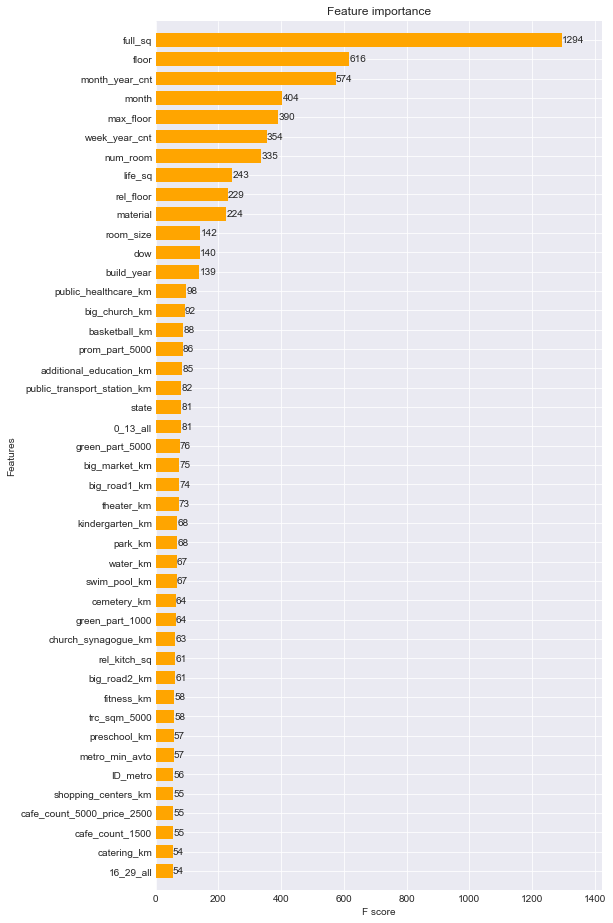

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=44, height=0.7, ax=ax, color="orange")
plt.show()

In [87]:
ytest = model.predict(Xtest_OWN)

# price/sq. meter * sq. meter = price

B["price_doc"] = ytest * B["full_sq"]

In [88]:
OWN_DATASET = B

In [89]:
OWN_DATASET = OWN_DATASET[["id", "full_sq", "price_doc"]]
OWN_DATASET.head()

,id,full_sq,price_doc
30472,30475,79.20,8.337097e+06
30474,30477,62.80,6.363771e+06
30475,30478,40.00,5.311581e+06
30476,30479,48.43,1.006973e+07
30477,30480,38.80,4.369938e+06


In [90]:
INV_DATASET = INV_DATASET[["id", "full_sq", "price_doc"]]
INV_DATASET.head()

,id,full_sq,price_doc
30471,30474,39.0,5.141904e+06
30473,30476,40.5,5.215561e+06
30479,30482,45.4,4.532466e+06
30484,30487,39.8,3.607554e+06
30488,30491,94.5,1.750925e+07


# E. Combining the predictions and exporting to a csv file

In [91]:
result = OWN_DATASET.append(INV_DATASET, ignore_index=True)
result = result.sort_values(by="id")
result = result.reset_index(drop=True).drop(columns="full_sq", axis=1)
result.head()

,id,price_doc
0,30474,5.141904e+06
1,30475,8.337097e+06
2,30476,5.215561e+06
3,30477,6.363771e+06
4,30478,5.311581e+06


In [92]:
result.to_csv('submission.csv', index=False)